In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from train_tools.utils import directory_setter
import copy

class InspectionHandler():
    """
    Inspector for learned network. The forward function of model must return (outputs, mark).
    outputs: (tensor) network output / mark: (tensor) marks consists of path indices.
    
    This module performs following inspections for different adaptive paths:
    1) Computational Cost vs Accuracy Trade-off
    2) Risk-Coverage Trade-off
    3) Confidence(Softmax Response) & Entropy distribution
    """
    def __init__(self, Network, dataloaders, dataset_sizes, device='cuda:0', phase='test',
                 num_path=1, path_cost=(1,), base_setting=True, use_small=False, save_path='./results/inspection/'):
        """
        [args]     (int) num_path : the number of adaptive paths of inference 
                   (tuple) path_cost : relative cost of path flops w.r.t. total flops ex) (0.3, 0.7, 1.15)
                                       default is None for 'no adaptive computation option'
                   (bool) use_samll : True if using seperated small network as a single path 
        """

        self.Network = Network.to(device).eval()
        self.dataloaders = dataloaders
        self.dataset_sizes = dataset_sizes
        self.device = device
        self.phase = phase
        self.num_path = num_path
        self.path_cost = path_cost
        self.use_small = 1 if use_small else 0
        self.save_path = save_path
        self.name = 'test' # default experiment name is 'test'
        
        if num_path != 1:
            assert num_path == len(path_cost), 'number of paths should have corresponding cost!'
        
        # build base inspection results
        self._result_dict_builder(phase=phase)
        
        if base_setting:
            self._baseline_setter(phase=phase)
            self._sr_rc_builder(phase=phase)
            print('Baselines & SR distribution result has updated.\n')
        
        
    def inference(self, phase='test', exit_cond=None):
        """
        Inference for given exit condition and dataset.
        
        [args]      (str) phase : use test or valid set 'valid' or 'test'
                    (list or tuple) exit_cond : exiting threshold condition for the paths ex) (0.9, 0.97, 0.84)
        
        [returns]   (int) total_acc : total accuracy
                    (list) path_acc : list of accuracy for paths
                    (list) path_ratio : list of count ratio for paths
                    (float) score : flops score for carried out inference
        """
        self._condition_setter(exit_cond)
        
        path_correct, path_count = [0] * (self.num_path), [0] * (self.num_path)
        size = self.dataset_sizes[phase]
                 
        with torch.no_grad():
            for inputs, labels in self.dataloaders[phase]:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Inference from Network
                outputs, mark = self._forward(inputs)
                pred = self._prediction(outputs)
                
                path_mark = []
                
                if self.use_small:
                    path_mark.append(mark == -1) # mark of smallnet is -1
                    
                for i in range(self.num_path-self.use_small):
                    path_mark.append(mark == i)
                
                for i, marker in enumerate(path_mark):
                    path_correct[i] += (pred[marker] == labels[marker]).sum().item()
                    path_count[i] += marker.sum().item()
                    
                    
        assert sum(path_count) == size, 'Total count must same with data count!'
        
        total_acc = round(sum(path_correct) / size, 4)
        
        path_acc, path_ratio = [], [] 
        
        for i in range(self.num_path):
            acc = -1 if path_count[i] == 0 else round((path_correct[i]/path_count[i]), 4) # assign -1 if no count
            ratio = round((path_count[i]/size), 4)
            path_acc.append(acc)
            path_ratio.append(ratio)

        flops_score = self._flops_checker(path_ratio)
        
        return total_acc, path_acc, path_ratio, flops_score

    
    def grid_inspector(self, start_cond, grid=0.01, clean_before=True):
        """
        Inspection for grid condition.
        
        [args]      (list or tuple) start_cond: start cond of condition ragne for paths ex) [0.5, 0.55, 0.7]
        """
        assert len(start_cond) == self.num_path-1, 'condition should 1 less than num_path!'

        if clean_before:
            self._clean_result_dict()
            
        condition_range = []
        condition_elem_num = []
        
        for start in start_cond:
            # build condition range for paths
            cond_size = int((1.0-start)//grid)
            cond_list = [start + x*grid for x in range(cond_size)]

            # confirm final threshold as 1.0
            if cond_list[-1] != 1:
                cond_list.append(1.0)
            
            condition_range.append(cond_list)
            condition_elem_num.append(len(cond_list))
        
        # build grid condition set
        condition_set = self._grid_cond_builder(condition_set=[], condition_range=condition_range)
        
        print('Starting Grid Inspection...\n')

        for i, exit_cond in enumerate(condition_set):
            total_acc, path_acc, path_ratio, flops_score = self.inference(phase=self.phase, exit_cond=exit_cond)
            self._result_dict_updater(exit_cond, total_acc, path_acc, path_ratio, flops_score)
            
            if (i%50 == 0) and (i > 0):
                print('Grid Inspection (%d/%d)'%(i, len(condition_set)))
                
        print('Inspection Finished!\n')
    
    
    def sr_rc_inspector(self, path_idx, phase='test'):
        """
        Inspects 1) logit distribution and top-5 entropy distribution for given path
                 2) sample prediction correctness and confidence values for them (sr, entropy)
        
        [args]      (int) path_idx : 0 <= path index. < num_paths 
                    (str) phase : use test or valid set 'valid' or 'test'
                    
        [returns]   (tuple) (max_sr_co, max_sr_inco) : lists of maximum softmax response for correct/incorrect samples
                    (tuple) (entropy_co, entropy_inco) : lists of entropy of top-5 softmax response for correct/incorrect samples
                    (tuple) (correctness, confidence_sr, confidence_ent) : tensors of correctness & confidence values
        """
        # Set full path condition
        condition = self._fullcond_setter(path_idx)
        self._condition_setter(condition)

        correctness, confidence_sr, confidence_ent = None, None, None
        
        max_sr_co, max_sr_inco = [], []
        entropy_co, entropy_inco = [], []
        
        size = self.dataset_sizes[phase]
        
        with torch.no_grad():
            for inputs, labels in self.dataloaders[phase]:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                # inference & prediction
                outputs, _ = self._forward(inputs)
                pred = self._prediction(outputs)
                
                # SR(softmax response)
                soft_out = F.softmax(outputs, dim=1)
                
                # maximum softmax response
                max_sr, _ = soft_out.max(dim=1) # maximum SR
                
                # top-10 entropy of softmax resnponse
                top5_out, _ = torch.topk(soft_out, 5) # top-5 SR
                entropy = (top5_out * -top5_out.log()).sum(dim=1) # top-5 SR entropy

                # Get correct/incorrect tensor
                co_tensor = pred == labels
                inco_tensor = pred != labels
                                    
                # get values for correct/incorrect samples
                co_sr, inco_sr = max_sr[co_tensor].tolist(), max_sr[inco_tensor].tolist()
                co_entropy, inco_entropy = entropy[co_tensor].tolist(), entropy[inco_tensor].tolist()

                # update max_sr list
                max_sr_co += co_sr
                max_sr_inco += inco_sr
                
                # update entropy list
                entropy_co += co_entropy
                entropy_inco += inco_entropy
                
                # update correct / confidence
                correctness = self._concat_tensor(correctness, co_tensor)
                confidence_sr = self._concat_tensor(confidence_sr, max_sr)
                confidence_ent = self._concat_tensor(confidence_ent, entropy)

        return (max_sr_co, max_sr_inco), (entropy_co, entropy_inco), (correctness, confidence_sr, confidence_ent)
    
    
    def _sr_rc_builder(self, phase='test'):
        """
        Updates sr_dist & risk-coverage for each paths
        
        [args]      (int) path_idx : 0 <= path index. < num_paths 
                    (str) phase : use test or valid set 'valid' or 'test'
        """                    
        for path_idx in range(self.num_path):
            (max_sr_co, max_sr_inco), (entropy_co, entropy_inco), \
            (correctness, confidence_sr, confidence_ent) = self.sr_rc_inspector(path_idx, phase)

            self.result_dict['max_sr_dist_'+str(path_idx)][0].append(max_sr_co)
            self.result_dict['max_sr_dist_'+str(path_idx)][1].append(max_sr_inco)
            self.result_dict['entropy_dist_'+str(path_idx)][0].append(entropy_co)
            self.result_dict['entropy_dist_'+str(path_idx)][1].append(entropy_inco)
            
            risk, coverage, perfect_coverage = self._rc_setter(correctness, confidence_sr, phase)
            self.result_dict['risk'].append(risk)
            self.result_dict['coverage'].append(coverage)
            self.result_dict['perfect_coverage'].append(perfect_coverage)

            
    def _rc_setter(self, correctness, confidence, grid_list, tolerance=0.001, phase='test'):
        """
        Calcuate risk-coverage values for given correctness tensor and confidence tensor.
        
        [args]      (Tensor) correctness : bool tensor for sample correctness
                    (Tensor) confidence : float tensor for sample confidence values
                    (list) grid_list : grid list to calculate risk-coverage trade-off
                    (float) tolerance : tolerance for the perfect learning
                            
        [returns]   (list) risk : a list of selective risk values
                    (list) coverage : a list of coverage values
                    (float) perfect_coverage : coverage when risk is at tolerance
        """
        risk, coverage = [], []
        perfect_coverage = 0.0
        size = self.dataset_sizes[phase]

        
        sorted_confidence, _ = confidence.sort()
        grid_list = [sorted_confidence[100*x] for x in range(int(size//100)-1)]
        grid_list.insert(0, 0) # make sure full coverage threshold exists
        
        for grid in grid_list:
            up_cond = confidence > grid
            count = up_cond.sum().item() # covered samples count
            correct = correctness[up_cond].sum().item() # selective accuracy
            
            risk_elem = 1 if count == 0 else round(1-correct/count, 4) # selective risk
            coverage_elem = round(count/size, 4) # coverage
            
            risk.append(risk_elem)
            coverage.append(coverage_elem)
    
        for i, risk_elem in enumerate(risk):
            if risk_elem <= tolerance:
                perfect_coverage = coverage[i]
                break

        return risk, coverage, perfect_coverage

            
    def _forward(self, x):
        """
        Inference for a single batch. 
        
        [returns]   (Tensor) outputs : inference result tensor
                    (Tensor) mark : mark tensor for paths. None if no adaptive path exits.
        """
        if self.path_cost is not None: # if use adaptive path
            outputs, mark = self.Network(x)
            
        else: # if do not use adaptive computation, all mark is 0
            outputs, mark = self.Network(x), torch.zeros(x.size(0))
        
        return outputs, mark
             
    
    def _prediction(self, outputs):
        """
        Prediction for a single batch inference result.
        
        [returns]   (Tensor) max_logits : maximum softmax output value tensor
                    (Tensor) pred : prediction result tensor
        """
        _, pred = torch.max(outputs, 1)
        return pred

    
    def _flops_checker(self, path_ratio):
        """
        Calculates total flops. Regards main network cost itself as 1.0
        
        [args]      (list) path_ratio: path ratio for paths
        
        [returns]   (float) score : flops score for given ratio list
        """
        score = 0
        
        if self.path_cost is not None: 
            for i, cost in enumerate(self.path_cost):
                score += (cost * path_ratio[i])
        
        else: # if do not use adaptive computation (path_cost == None)
            score = 1

        return score
    
    
    def _condition_setter(self, exit_cond):
        """
        Sets exiting threshold for each paths in Network.
        
        [args]      (list or tuple) cond: exiting threshold condition for the paths ex) (0.9, 0.97, 0.84)
        """
        if not exit_cond: # if exit_cond is not exist
            pass
        
        else:
            assert (self.num_path-1) == len(exit_cond), 'the number of exit_cond should 1 less than the number of paths!'
            # [!Caution] self.Network must have method 'condition_updater'
            self.Network.condition_updater(exit_cond) 


    
    def _fullcond_setter(self, path_idx):
        """
        Returns full exiting condition for given path.
        
        [args]      (int) path_idx: path index (0 <= path_idx < num_paths)
        
        [returns]   (list) condition : condition list for corresponding path
        """
        condition = [1] * (self.num_path-1) # coindition length should 1 less than path length
        if path_idx < self.num_path-1:
            condition[path_idx] = 0 # sets threshold as 0 for full exiting ex) [1,1,1,0,1]
        
        return condition
    

    def _grid_cond_builder(self, condition_set, condition_range):
        """
        Recursively builds list of exit_cond for given condition ranges.
        
        [args]      (list) condition_set : list of exit_cond. empty list at first
                    (list) condition_range : list of condition range tuples
                    
        [returns]   (list) condition_set : list of exit_cond (recursive result)
        """
        if len(condition_range) == 0: 
            # return if no more condition range exists.
            return condition_set

        else:
            if not condition_set: # if condition_set is empty (initial state)
                # append conditions for empty list
                for cond in condition_range[-1]:
                    condition_set.append([cond])
                condition_set = self._grid_cond_builder(condition_set, condition_range[:-1])
            
            else:
                new_condition_set = []
                
                # for condition range of a specific path
                for i in range(len(condition_range[-1])):
                    condition_subset = copy.deepcopy(condition_set) # make sure 1 to 1 mapping in memory
                    # for conditions which already built
                    for j in range(len(condition_subset)):
                        condition_subset[j].insert(0, condition_range[-1][i]) # insert path condition
                    new_condition_set += condition_subset

                condition_set = new_condition_set
                condition_set = self._grid_cond_builder(condition_set, condition_range[:-1])

        return condition_set

    
    def _baseline_setter(self, phase='test'):
        """
        Updates baseline accuracy for each path.
        
        [args]      (str) phase : use test or valid set 'valid' or 'test '
        """
        baseline = []
        
        for i in range(self.num_path): 
            condition = self._fullcond_setter(i)
            accuracy, _, _, _ = self.inference(phase=phase, exit_cond=condition)
            baseline.append(accuracy)
        
        self.result_dict['baseline'] = baseline    
    
    
    def _clean_result_dict(self):
        """
        Cleans result_dict about grid inspection results.
        The information of baseline, logitdist, path_cost remains.
        """
        self.result_dict['total_acc'] = []
        self.result_dict['flops_score'] = []
        
        for i in range(self.num_path):
            self.result_dict['path_acc_' + str(i)] = []
            self.result_dict['path_ratio_' + str(i)] = []
            self.result_dict['path_cond_' + str(i)] = []
          
        
    def _result_dict_builder(self, phase):
        """
        Builds a dictionary to save results
        """
        result_dict = {
            'phase' : phase,
            'total_acc': [],
            'flops_score' : [],
            'perfect_coverage' : []
        }
        
        result_dict['path_cost'] = self.path_cost
        
        for i in range(self.num_path):
            result_dict['path_acc_' + str(i)] = []
            result_dict['path_ratio_' + str(i)] = []
            result_dict['path_cond_' + str(i)] = []
            result_dict['risk'] = []
            result_dict['coverage'] = []
            result_dict['max_sr_dist_'+ str(i)] = [[], []]  # [co_dist, inco_dist]
            result_dict['entropy_dist_'+ str(i)] = [[], []] # [co_dist, inco_dist]

        self.result_dict = result_dict
            
    
    def _result_dict_updater(self, exit_cond, total_acc, path_acc, path_ratio, flops_score):
        """
        Updates inference result to result_dict
        """        
        assert len(path_acc) == len(path_ratio), 'path number should same for accuracy and ratio!'

        self.result_dict['total_acc'].append(total_acc)
        self.result_dict['flops_score'].append(flops_score)
        
        for i in range(self.num_path):
            self.result_dict['path_acc_'+str(i)].append(path_acc[i])
            self.result_dict['path_ratio_'+str(i)].append(path_ratio[i])
            
            if i < self.num_path-1:
                path_cond = exit_cond[i]
            else:
                path_cond = -1
            
            self.result_dict['path_cond_'+str(i)].append(path_cond)

            
    def _baseline_setter(self, phase='test'):
        """
        Updates baseline accuracy for each path.
        
        [args]      (str) phase : use test or valid set 'valid' or 'test '
        """
        baseline = []
        
        for i in range(self.num_path): 
            condition = self._fullcond_setter(i)
            accuracy, _, _, _ = self.inference(phase=phase, exit_cond=condition)
            baseline.append(accuracy)

        self.result_dict['baseline'] = baseline    
    
    
    def _concat_tensor(self, base, tensor):
        """
        Concat tensor if already exist.

        [args]      (Tensor) base : base tensor to be updated
                    (Tensor) tensor : tensor to concat to the base
        """
        if base is None:
            base = tensor
        else:
            base = torch.cat((base, tensor), dim=0)
        
        return base
    

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from models.adaptivecomp.utils import LogitCond, SL_Pair
from data_utils import cifar_100_setter, cifar_10_setter
from models.ResNet import resnet101, resnet18
from models.ResNet2 import resnet8
from models.DenseNet import densenet40

dataloaders, dataset_sizes = cifar_100_setter(root='./data/cifar100')
#dataloaders, dataset_sizes = cifar_10_setter(root='./data/cifar10')


#smallnet = densenet40(num_classes=10)
#smallnet.load_state_dict(torch.load('./results/trained_models/densenet40_ce_cifar10/trained_model.pth'))
#largenet = densenet40(num_classes=10)
#largenet.load_state_dict(torch.load('./results/trained_models/densenet40_sm_cifar10/trained_model.pth'))

smallnet = resnet8(num_classes=100)
smallnet.load_state_dict(torch.load('./results/trained_models/resnet8_ce/trained_model.pth'))
largenet = resnet8(num_classes=100)
largenet.load_state_dict(torch.load('./results/trained_models/resnet8_sm/trained_model.pth'))

model = SL_Pair(smallnet, largenet, exit_cond=1, num_classes=100)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [117]:
inspector = InspectionHandler(model, dataloaders, dataset_sizes, num_path=2, path_cost=(1.0, 1.0), use_small=True)

Baselines & SR distribution result has updated.



In [118]:
result_dict = inspector.result_dict

In [119]:
result_dict['perfect_coverage']

[0.0399, 0.0799]

In [130]:
def RC_plotter(risk, coverage, perfect_coverage, name='test'):
    fig, ((ax1)) = plt.subplots(1, 1, figsize=(7, 5))
    #fig.suptitle(name, fontsize=20)
    
    color = ['red', 'blue']
    
    for i in range(len(risk)):
        ax1.set(title='Risk-Coverage Curve ResNet8 Cifar100', xlabel='Risk(r)', ylabel='Coverage(c)')
        ax1.plot(risk[i], coverage[i], color=color[i], linestyle='-', markersize=2, alpha=0.7)
        ax1.set_ylim(0.0, 1.0)
        ax1.set_xlim(0, 0.45)
        #ax1.set_xlim(0.00105, 0.08)
        #plt.annotate('small counties; most vote for McCain', , weight='bold',
        #        , fontsize=10,)

        ax1.annotate('r*(%0.4f, %0.2f)'%(risk[i][0], coverage[i][0]), xy=(risk[i][0], coverage[i][0]),  xytext=(risk[i][0]-0.01, coverage[i][0]-0.1*(1+i)), color=color[i], \
                     fontsize=10, weight='bold', arrowprops=dict(arrowstyle="->", color=color[i]))

        ax1.annotate('c*(%0.3f, %0.3f)'%(0.001, perfect_coverage[i]), xy=(0.001, perfect_coverage[i]), xytext=(0.001+0.005, perfect_coverage[i]-0.12*(1+i)), color=color[i], \
                     fontsize=10, weight='bold',arrowprops=dict(arrowstyle="->", color=color[i]))

    ax1.legend(['ce', 'sm'], loc=4)
    ax1.grid()

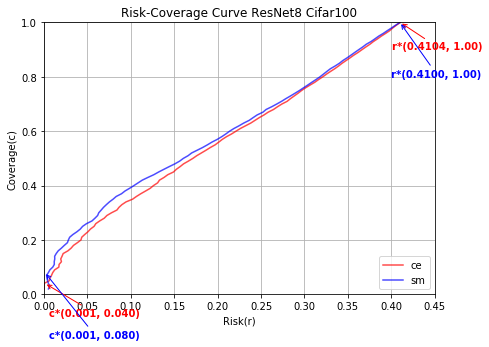

In [131]:
RC_plotter(result_dict['risk'], result_dict['coverage'], result_dict['perfect_coverage'])

In [103]:
def logit_plotter(sr_dist, entropy_dist, name='test'):
    (max_logit_co, max_logit_inco), (entropy_co, entropy_inco) = sr_dist, entropy_dist
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(name, fontsize=20)
    
    ax1.set(title='Max softmax outputs(Exit Module)', xlabel='softmax max value', ylabel='data count')
    ax1.hist(max_logit_co, color='brown', bins=[0.95+x*0.0005 for x in range(210)], alpha=0.5)
    ax1.hist(max_logit_inco, color='gray', bins=[0.95+x*0.0005 for x in range(210)], alpha=0.5)
    ax1.set_ylim(0, 100)
    ax1.set_xlim(0.95, 1)
    ax1.legend(['correct samples', 'incorrect samples'])
    ax1.grid()
    
    ax2.set(title='Entropy of Top10 softmax outputs(Exit Module)', xlabel='Top10 softmax entropy', ylabel='data count')
    ax2.hist(entropy_co, color='brown', bins=[x*0.01 for x in range(450)], alpha=0.5)
    ax2.hist(entropy_inco, color='gray', bins=[x*0.01 for x in range(450)], alpha=0.5)
    ax2.set_ylim(0, 200)
    ax2.set_xlim(0, 2.5)
    ax2.legend(['correct samples', 'incorrect samples'])
    ax2.grid()
        
    
    fig.show()
    fig.savefig('./%s.png' % name)
    print('%s inspection graph is saved' % name)    

crossentropy inspection graph is saved


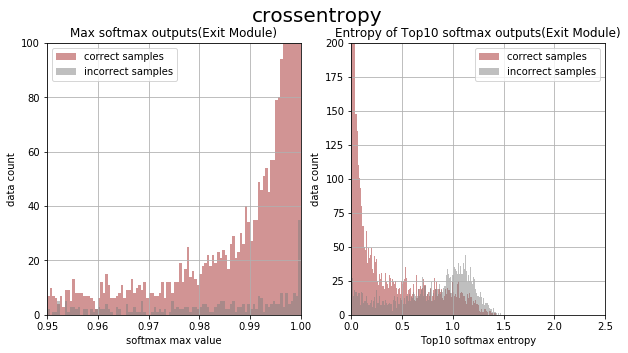

In [104]:
logit_plotter(result_dict['max_sr_dist_0'], result_dict['entropy_dist_0'], name='crossentropy')

softsmoothing inspection graph is saved


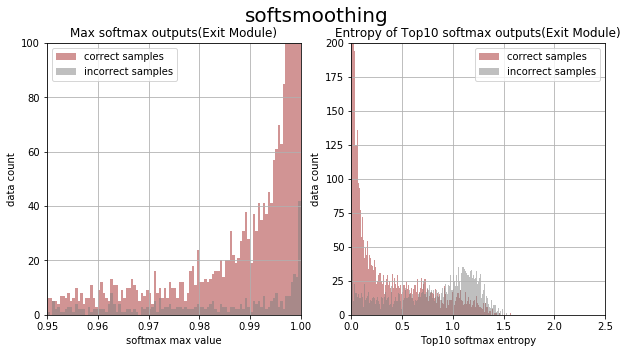

In [105]:
logit_plotter(result_dict['max_sr_dist_1'], result_dict['entropy_dist_1'], name='softsmoothing')